## <div align="center">Assignment for Module 3, CQF</div>
### <div align="right"><i>done by Sergei Beshenov,<br> Summer 2023 cohort</br></i></div>

**<u>Introduction</u>:** Short-term asset return is a challenging quantity to predict. Efficient markets produce
near-Normal daily returns with no significant correlation between $r_t$
, $r_{t−1}$. This exam is a limited
exercise in supervised learning. We are expected to explore multiple features or may use a set of
features from Table 1 without an expectation of predictive powers. Original and final selected features
should be sufficiently large.

## Objective
The objective is to produce a model to predict positive moves (up trend) using machine learning
model as specified in the below section. A proposed solution should be comprehensive with the
detailed feature engineering and model architecture.
* Choose one ticker of your interest from the index, equity, ETF, crypto token, or commodity.
* Predict trend only, for a short-term return (example: daily, 6 hours). Limit prediction to
binomial classification: the dependent variable is best labeled [0, 1]. Avoid using [-1, 1] as class
labels.
* Analysis should be comprehensive with detailed feature engineering, data pre-processing, model
building, and evaluation.

Devise your own approach on how to categorise extremely small near-zero returns (drop from
training sample, group with positive/negative). The threshold will strongly depend on your
ticker. Example: small positive returns below 0.25% can be labelled as negative.

\begin{equation}
\begin{aligned}
&\text { Table 1: Features List }\\
&\begin{array}{l|l|l}
\hline \text { Feature } & \text { Formula } & \text { Description } \\
\hline O-C, H-L & \text { Open - Close, High - Low } & \text { intraday price range } \\
\hline \text { Sign } & \operatorname{sign}\left[\mathrm{rt}=\ln \frac{P_t}{P_{t-1}}\right] & \text { sign of return or momentum } \\
\hline \text { Past Returns } & r_{t-1}, r_{t-2}, \ldots & \text { lagged returns } \\
\hline \text { Momentum } & P_t-P_{t-k} & \text { price change over k period } \\
\hline \text { Moving Average } & S M A_i=\frac{1}{n} \sum_{i=0}^{n-1} P_{t-i} & \text { simple moving average } \\
\hline \text { Exponential MA } & E M A_i=E M A_{t-1}+\alpha\left[P_t-E M A_{t-1}\right] & \text { recursive, } \alpha=2 /\left(N_{\text {obs }}+1\right) \\
\hline
\end{array}
\end{aligned}
\end{equation}

Number of features to include is a design choice. There is no one recommended set of features for all
assets. Length of dataset is another design choice. If predicting short-term return sign (for daily move),
then training and testing over up to 5-year period should be sufficient. Making sense of instructions
below is part of the task: the tutor will not assist in designing your computational implementation.
    
## Questions
### 1. What are voting classifiers in ensemble learning?
#### Answer:
Voting classifiers in ensemble learning combine multiple individual classifiers to make predictions. They can be either hard or soft voting. In hard voting, the final prediction is based on majority voting. In soft voting, probabilities from individual classifiers are averaged to determine the final prediction. Voting classifiers are used to enhance prediction accuracy by leveraging the strengths of different classifiers. They are commonly applied in classification tasks within machine learning.

### 2. Explain the role of the regularization parameter C in a Support Vector Machine (SVM) model. How does varying C affect the model’s bias and variance trade-off?
#### Answer:

The regularization parameter C in a Support Vector Machine (SVM) model controls the balance between the fit to the training data and the generalization ability of the model. C controls the penalty for errors in the classification of training points.

When the value of C is low, the SVM will allow a larger number of misclassified training points to achieve a smoother and less complex decision function. This can result in a model with higher bias and lower variance, as it may ignore some noisy points in the training set.

On the other hand, when the value of C is high, the SVM will try to correctly classify most or all of the training points. This can result in a more complex decision function that is sensitive to variations in the training data. In this case, the model may have lower bias but higher variance, which can lead to overfitting to the training data and reduced generalization ability to new data.

In summary, a lower C value smoothes the model and increases the bias with less variance, while a higher C value fits the training data more and increases the variance with less bias. The optimal value of C depends on the complexity of the problem and the amount of noise in the data.

### 3. Follow the 7-steps to model building for your selected ticker,
(a) produce a model to predict positive moves (up trend) using Random Forest Classifier.

(b) tune hyperparameters for the estimator and present the best model.

(c) investigate the prediction quality using area under ROC curve, confusion matrix and classification report.

**Note**: Choice and number of hyperparameters to be optimized for the best model are design choices.
Use of experiment tracking tools like MLFlow is allowed [refer to Advanced Machine Learning Workshop - II for sample implementation].

Based on CQF Python lectures and labs, the following 7 steps are defined for further modeling:

| Steps | Workflow | Remarks |
| :--- | :--- | :--- |
| Step 1 | Ideation | Idea statement: Predict next trading day index price from the given dataset |
| Step 2 | Data Collection | Load the dataset from Yahoo finance |
| Step 3 | Exploratory Data Analysis | Study summary statistics |
| Step 4 | Cleaning Dataset | Data already cleaned, no further imputation required |
| Step 5 | Transformation | Feature engineering & Feature selection |
| Step 6 | Modeling & Hyperparameter tuning | Building and training Random Forest Classifier |
| Step 7 | Validation & Metrics | Validattion of results + bonus = trading strategy implementation |

In [1]:
# Base Libraries
import pandas as pd
import numpy as np

# Fetching data
import yfinance as yf

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# plot params
#plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = [10.0, 3.0]
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 1.5

# plt.rcParams['figure.figsize'] = (20,7)
# plt.style.use('fivethirtyeight')
# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split,GridSearchCV, RandomizedSearchCV, TimeSeriesSplit,cross_val_score)
# Classifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# metrics
from sklearn.metrics import (precision_recall_curve, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, auc)
from sklearn.metrics import (classification_report, confusion_matrix)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Step 1. Ideation

### 1.1. Objective

Predict next trading day price movement of a commodity. Here, we are talking about binary classification task, i.e. prediction of 1 (upward movement) or 0 (downward movement). Our ultimate goal is to predict upward movement, however, we need to make sure that model can distinguesh both directions correctly in most of the cases.


### 1.2. Approach - Random forest
Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. It is widely used for classification and regression tasks.

Random Forest harnesses the power of decision trees along with the concept of bootstrapped sampling and aggregation to improve prediction accuracy and reduce overfitting. Here are the key components of a Random Forest model:

#### 1. Bootstrapped Sampling:
   - Randomly select a subset of the original dataset, with replacement, to create a new training dataset. This process is known as bootstrapped sampling. Typically, the size of the new dataset is the same as the original dataset.

#### 2. Decision Tree Construction:
   - Construct decision trees using the bootstrapped samples. Each tree is built independently using a standard criteria for tree split like Gini, Entropy, Log-loss.
   - Randomly select a subset of input features at each node of the decision tree to consider for splitting. This promotes diversity among the individual trees.
   - Recursively split the data based on different features until a stopping condition (e.g., maximum depth or minimum samples) is met.

#### 3. Ensemble Aggregation:

   - For classification tasks:
     - Each decision tree in the Random Forest independently predicts the class probabilities for a given input data point.
     - The final prediction is obtained by aggregating the predictions of all the trees using majority voting.

   - For regression tasks:
     - Each decision tree predicts a continuous value for a given input data point.
     - The final prediction is obtained by averaging the predictions of all the trees.

By combining the predictions of multiple decision trees, Random Forest reduces the impact of individual tree biases and variance, resulting in more accurate and robust predictions.

The Random Forest algorithm can handle high-dimensional data, provide feature importance estimations, and effectively handle missing data and outliers.

Here are some common criteria used in Random Forest Classifier:

- Gini Index:
$$
\text{Gini}(p) = 1 - \sum_{c=1}^{C} p_c^2
$$

- Entropy:
$$
\text{Entropy}(p) = -\sum_{c=1}^{C} p_c \log_2(p_c)
$$

For a regression task, the most common criteria will be MSE.

These formulas play a crucial role in decision tree construction within the Random Forest algorithm and in aggregating the predictions from the ensemble of trees.

Random Forest combines the strength of multiple decision trees to achieve accurate predictions and overcome the limitations of individual trees, making it a powerful and widely used machine learning method.

### 1.3. Choice of a commodity futures
Given the initial idea to forecast a commodity price, it wasn't obvious which one to choose. Here we proceed with the following steps:

- 1. Parse available tickets from https://finance.yahoo.com/commodities/ by using **beautiful soup** library.
- 2. Run a basic Random Forest Classifier model with some arbitrary parameters that will prevent the model from overfitting (max depth 15, max leaf node 10) as RF is prone to overfiting when used loosely.
- 3. Check accuracy and AUC metrics to choose a commodity with the highest potential for the perspective model.

The best candidate has been chosen based on the higherst AUC And Test Accuracy score:

* Rough Rice Futures (Test accuracy: 0.54, AUC: 0.62 )

However, other commodities we close and even better at test accuracy, I found it interesting to model Rice Futures. 

| Ticker | Name | Train Accuracy | Test Accuracy | AUC |
|--------|------|----------------|---------------|-----|
| OJ=F | Orange Juice Jan 24 | 0.8492 | 0.54 | 0.4203 |
| CT=F | Cotton Dec 23 | 0.7478 | 0.4377 | 0.4261 |
| CC=F | Cocoa Dec 23 | 0.7617 | 0.4766 | 0.4517 |
| KC=F | Coffee Dec 23 | 0.7331 | 0.4684 | 0.466 |
| HO=F | Heating Oil Nov 23 | 0.7374 | 0.4626 | 0.4763 |
| SB=F | Sugar # 11 Mar 24 | 0.6741 | 0.5029 | 0.4797 |
| HE=F | Lean Hogs Futures,Dec-2023 | 0.695 | 0.5043 | 0.4814 |
| SI=F | Silver | 0.7363 | 0.4755 | 0.4825 |
| ZC=F | Corn Futures,Dec-2023 | 0.6837 | 0.4799 | 0.5078 |
| MGC=F | Micro Gold Futures,Dec-2023 | 0.7215 | 0.4709 | 0.5136 |
| RB=F | RBOB Gasoline Nov 23 | 0.7165 | 0.5374 | 0.514 |
| ZS=F | Soybean Futures,Jan-2024 | 0.7007 | 0.4713 | 0.5175 |
| NG=F | Natural Gas Nov 23 | 0.7065 | 0.5172 | 0.5201 |
| KE=F | KC HRW Wheat Futures,Dec-2023 | 0.7424 | 0.4971 | 0.5213 |
| CL=F | Crude Oil | 0.7283 | 0.5174 | 0.5232 |
| BZ=F | Brent Crude Oil Last Day Financ | 0.6847 | 0.5331 | 0.5299 |
| PA=F | Palladium Dec 23 | 0.7488 | 0.4396 | 0.5315 |
| ZO=F | Oat Futures,Dec-2023 | 0.733 | 0.5389 | 0.5414 |
| LE=F | Live Cattle Futures,Dec-2023 | 0.705 | 0.5287 | 0.5467 |
| SIL=F | Micro Silver Futures,Dec-2023 | 0.7474 | 0.5296 | 0.5561 |
| GC=F | Gold | 0.7408 | 0.5316 | 0.5595 |
| PL=F | Platinum Jan 24 | 0.7312 | 0.5092 | 0.5627 |
| ZL=F | Soybean Oil Futures,Dec-2023 | 0.7029 | 0.5316 | 0.572 |
| HG=F | Copper Dec 23 | 0.7271 | 0.5661 | 0.5724 |
| **ZR=F** | **Rough Rice Futures,Jan-2024** | **0.6862** | **0.5362** | **0.6208** |

### Step 2. Load Data

We download **daily** data from OCT 1, 2016 to 30 SEP, 2023 making **a 7-year long dataset**. This data contains only working 

In [2]:
# Load locally stored data
def load_data(ticker, start, end):
    df =  yf.download(ticker, start, end, progress=False)
    return df

df1 = load_data('ZR=F', start='2016-09-30', end='2023-09-30')   
# Check first 5 values
print('The loaded data we work with can be seen below. We have got Open, Close (+Adj.), High and Low prices'+
      ' as well as Volume to be used for further modeling.')
print('The oldest observations:')
df1.head(7)

The loaded data we work with can be seen below. We have got Open, Close (+Adj.), High and Low prices as well as Volume to be used for further modeling.
The oldest observations:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-09-30 00:00:00-04:00,977.5,991.0,977.5,988.5,988.5,610
2016-10-03 00:00:00-04:00,983.5,1036.5,983.5,1006.5,1006.5,959
2016-10-04 00:00:00-04:00,1005.0,1014.0,1001.0,1009.5,1009.5,835
2016-10-05 00:00:00-04:00,1007.5,1009.0,997.5,1004.0,1004.0,276
2016-10-06 00:00:00-04:00,1003.5,1013.0,1000.5,1011.0,1011.0,253
2016-10-07 00:00:00-04:00,1005.5,1017.0,1000.5,1009.5,1009.5,290
2016-10-11 00:00:00-04:00,1022.0,1040.0,1022.0,1039.5,1039.5,917


In [3]:

print('The newest observations:')
df1.tail(3)

The newest observations:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-27 00:00:00-04:00,1619.0,1626.5,1605.5,1617.5,1617.5,423
2023-09-28 00:00:00-04:00,1610.0,1620.0,1607.0,1613.0,1613.0,428
2023-09-29 00:00:00-04:00,1609.0,1609.0,1582.5,1591.0,1591.0,637


We can see the dynamic of these features below. Apparently, in periods of high volatility, we observe a greater distance between High and Low prices. Volumes do possess some pattern in their dynamic: this pattern is seasonal and may refer to harvest season, as we see a dropdown in volumes in the second half of each year.

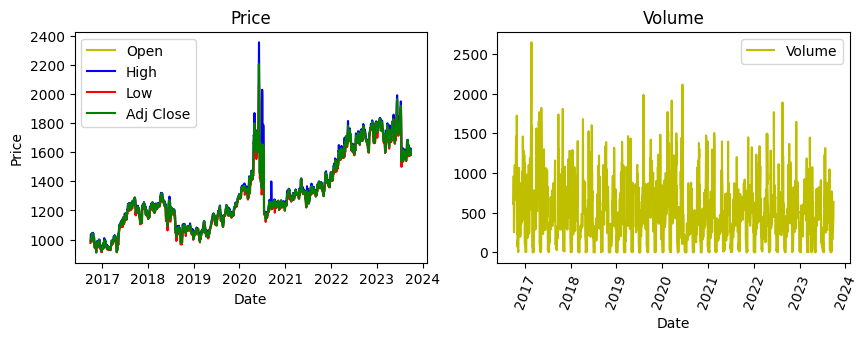

In [4]:
fig = plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.plot( df1['Open'],"y-")
plt.plot(df1['High'],"b-")
plt.plot(df1['Low'],"r-")
plt.plot(df1['Adj Close'],"g-")
plt.xlabel("Date")
plt.title('Price')
plt.ylabel('Price')
plt.legend(['Open','High', 'Low', 'Adj Close'])

plt.subplot(122)
plt.plot(df1['Volume'],"y-")

plt.xlabel("Date")
plt.title('Volume')
plt.legend(['Volume'])
plt.xticks(rotation=70)

plt.show()

## Step 3. EDA of Original dataset


Let's see the regular descriptive statistics to check for distribution, anomalities and outliers:


In [5]:
# Descriptive statistics
df1.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000,1747.000000
mean,1324.897825,1335.690040,1314.636234,1324.970235,1324.970235,490.479107
std,251.372663,255.331064,247.942063,251.255487,251.255487,387.525462
min,912.500000,912.500000,912.500000,912.500000,912.500000,0.000000
25%,1152.500000,1161.000000,1138.750000,1151.000000,1151.000000,188.500000
50%,1253.000000,1262.000000,1248.000000,1254.000000,1254.000000,450.000000
75%,1554.750000,1566.250000,1545.750000,1554.750000,1554.750000,717.000000
max,2221.000000,2356.500000,2063.000000,2206.500000,2206.500000,2646.000000


From the table above we see that Volume can be 0 for some days. Let us check the how many days didn't have volumes at all.

In [6]:
# Check zeros
df1.eq(0).sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume       51
dtype: int64

Result: We observed 51 days of no volumes. These can be issue for feature engineering later on (e.g. % change calculation), so the features where dividing by volume is required will not be added to the dataset

In [7]:
if df1.loc[df1['Volume'] == 0,'Volume'].count()/df1['Volume'].count() < 0.01: 
    # we do replacement only if number of 0 is insignificant (less than 1%)
    df1['Volume'] = df1['Volume'].replace(0,1)

Text(0.5, 1.0, 'Boxplot of Features')

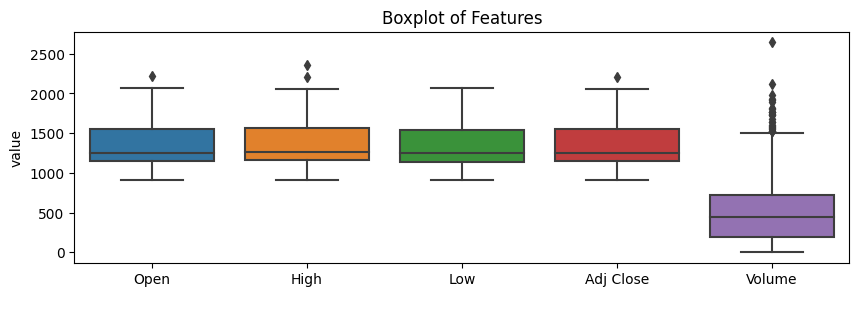

In [8]:
# study the distribution, boxplot
bplot = df1.drop(['Close'], axis = 1)
sns.boxplot(x='variable', y='value', data=pd.melt(bplot))
plt.xlabel(' ')
plt.title('Boxplot of Features')

## Step 4. Cleaning & Imputation
Data is already cleaned. No further processing or imputation required.
Below you can see the number of missing (null vales in the dataset):

In [9]:
# Check for missing values
df1.isnull().sum()


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Step 5. Transformation
### 5.1. Feature engineering
Features or Predictors are also known as an independent variable which are used to determine the value of the target variable. We will derive a features set from the original dataset.


\begin{equation}
\begin{aligned}
&\text {Features List used for the modeling:}\\
&\begin{array}{l|l|l|l|l}
\hline \text { Feature } & \text { Formula } & \text { Description } & \text { Period }  & \text { Short name } \\
\hline O-C, H-L & \text { Open - Close, High - Low } & \text { intraday price range } & \text {,5,10,20} & \text {HC#}\\
\hline \text { Sign } & \operatorname{sign}\left[\mathrm{rt}=\ln \frac{P_t}{P_{t-1}}\right] & \text { sign of return } & \text {,5,10,20} & \text {SIGN#}\\
\hline \text { Past Returns } & r_{t-1}, r_{t-2}, \ldots & \text { lagged returns }&  \text {,5,10,20} & \text {RETN#}\\
\hline \text { Stand dev. of return } &\sqrt{\frac{1}{N-1} \sum_{i=1}^{N} (r_t - \bar{r})^2}& \text { stand. dev. of returns }&  \text {,5,10,20} & \text {STD#}\\
\hline \text { % Changes } & P_{t-1}/ P_{t-2}, \ldots & \text { % Changes }&  \text {,5,10,20} & \text {PCHG# / VPCH#}\\
\hline \text { Gap } & \frac{1}{n} \sum_{i=0}^{n-1} (P_{t-i}^{Open}-P_{t-1-i}^{Close}) & \text { Gap and average gap per period }&  \text {,5,10,20} & \text {GAP#}\\
\hline \text {P / Moving Average } & P_{t}/S M A_i : S M A_i=\frac{1}{n} \sum_{i=0}^{n-1} P_{t-i} & \text {SMA for price/volume}&  \text {,5,10,20} & \text {MA# / VA#} \\
\hline \text { P / Exponential MA} & P_{t}/E M A_i : E M A_{t-1}+\alpha\left[P_t-E M A_{t-1}\right] & \text { recursive, } \alpha=2 /\left(N_{\text {obs }}+1\right)&  \text {,5,10,20} & \text {EMA#} \\
\hline \text { Upper/Lower Bound} & \text {MA +/- stand.dev.(MA)*2.33} & \text {99% conf. interval for MA}& \text {,5,10,20} & \text {UB# / LB#} \\
\hline
\end{array}
\end{aligned}
\end{equation}

In [10]:
# create features
def create_features(frame):
    df = frame.copy()
    multiplier_ = 2.33
    # features
    df['OC'] = df['Adj Close'] - df['Open']
    df['HC'] = df['High'] - df['Low'] 
    df['GAP'] = df['Open'] - df['Adj Close'].shift(1) 
    df['RET'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['SIGN'] = np.sign(df['RET'])
    for i in [5, 10, 20]:
        df['PCHG' + str(i)] = df['Adj Close'].pct_change(i)
        df['RET' + str(i)] = df['RET'].rolling(i).sum()
        df['MA' + str(i)] =  df['Adj Close']/df['Adj Close'].rolling(i).mean()
        if (df['Volume'] != 0).all():
            df['VCHG' + str(i)] = df['Volume'].pct_change(i)
            df['VCHG' + str(i)] = df['Volume'].pct_change(i)
        df['VMA' + str(i)] =  df['Volume']/df['Volume'].rolling(i).mean()
        df['OC'+ str(i)] = df['OC'].rolling(i).mean()
        df['HC'+ str(i)] = df['HC'].rolling(i).mean()
        df['SIGN'+str(i)] = np.sign(df['RET' + str(i)])
        df['GAP'+ str(i)] = df['GAP'].rolling(i).mean()
        df['STD'+ str(i)] = df['RET'].rolling(i).std()
        df['UB'+str(i)] = df['Adj Close'].rolling(i).mean() + df['Adj Close'].rolling(i).std() * multiplier_
        df['LB'+str(i)] = df['Adj Close'].rolling(i).mean() - df['Adj Close'].rolling(i).std() * multiplier_ 
        df['EMA'+ str(i)] =  df['Adj Close']/df['Adj Close'].ewm(span=i,adjust=False).mean()
        
    # drop NaN values
    df['Label'] = df['Adj Close'].shift(-1)
    df.dropna(inplace=True)
    label = df['Label']
    
    df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Label', 'Close'], axis=1, inplace=True)
    return df, label


Please see the exaustive list features created for the analsysis: 

In [11]:
X,label = create_features(df1)
y = label.copy()
print(X.columns)
print("The total num: of created features is :", X.shape[1])

Index(['OC', 'HC', 'GAP', 'RET', 'SIGN', 'PCHG5', 'RET5', 'MA5', 'VMA5', 'OC5',
       'HC5', 'SIGN5', 'GAP5', 'STD5', 'UB5', 'LB5', 'EMA5', 'PCHG10', 'RET10',
       'MA10', 'VMA10', 'OC10', 'HC10', 'SIGN10', 'GAP10', 'STD10', 'UB10',
       'LB10', 'EMA10', 'PCHG20', 'RET20', 'MA20', 'VMA20', 'OC20', 'HC20',
       'SIGN20', 'GAP20', 'STD20', 'UB20', 'LB20', 'EMA20'],
      dtype='object')
The total num: of created features is : 41


### 5.2 EDA for feature scaling (?)


In general, it is not necessary to use feature scaling (e.g., scaling your data using a scaler such as StandardScaler or MinMaxScaler) when using the Random Forest algorithm. **Random Forests are based on decision trees which are not affected by the scale of the features.**

This time we proceed furher with no scaling applied. The nice picture below to provide some sense of feature distributions:

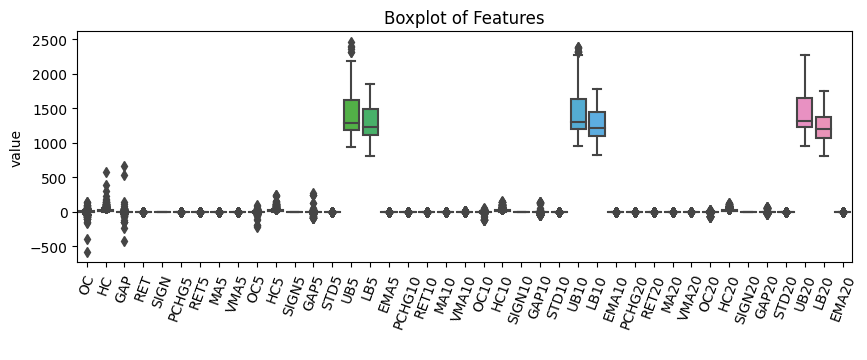

In [12]:
# study the distribution, boxplot
sns.boxplot(x='variable', y='value', data=pd.melt(X))
plt.xlabel(' ')
plt.title('Boxplot of Features')
plt.xticks(rotation=70)
plt.show() 

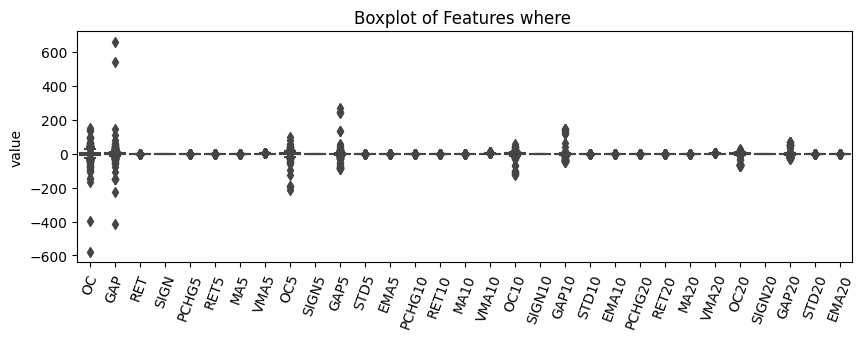

In [13]:
# study the distribution, boxplot
df3 = X.loc[:,np.mean(X, axis=0)<10]
sns.boxplot(x='variable', y='value', data=pd.melt(df3))
plt.xlabel(' ')
plt.title('Boxplot of Features where ')
plt.xticks(rotation=70)
plt.show() 

We see that some of the features possess skewed distributions and outliers, though we expect desicion tries to handle these.

### 5.3 Feature selection
#### 5.3.1 Correlation analysis (Filter method)

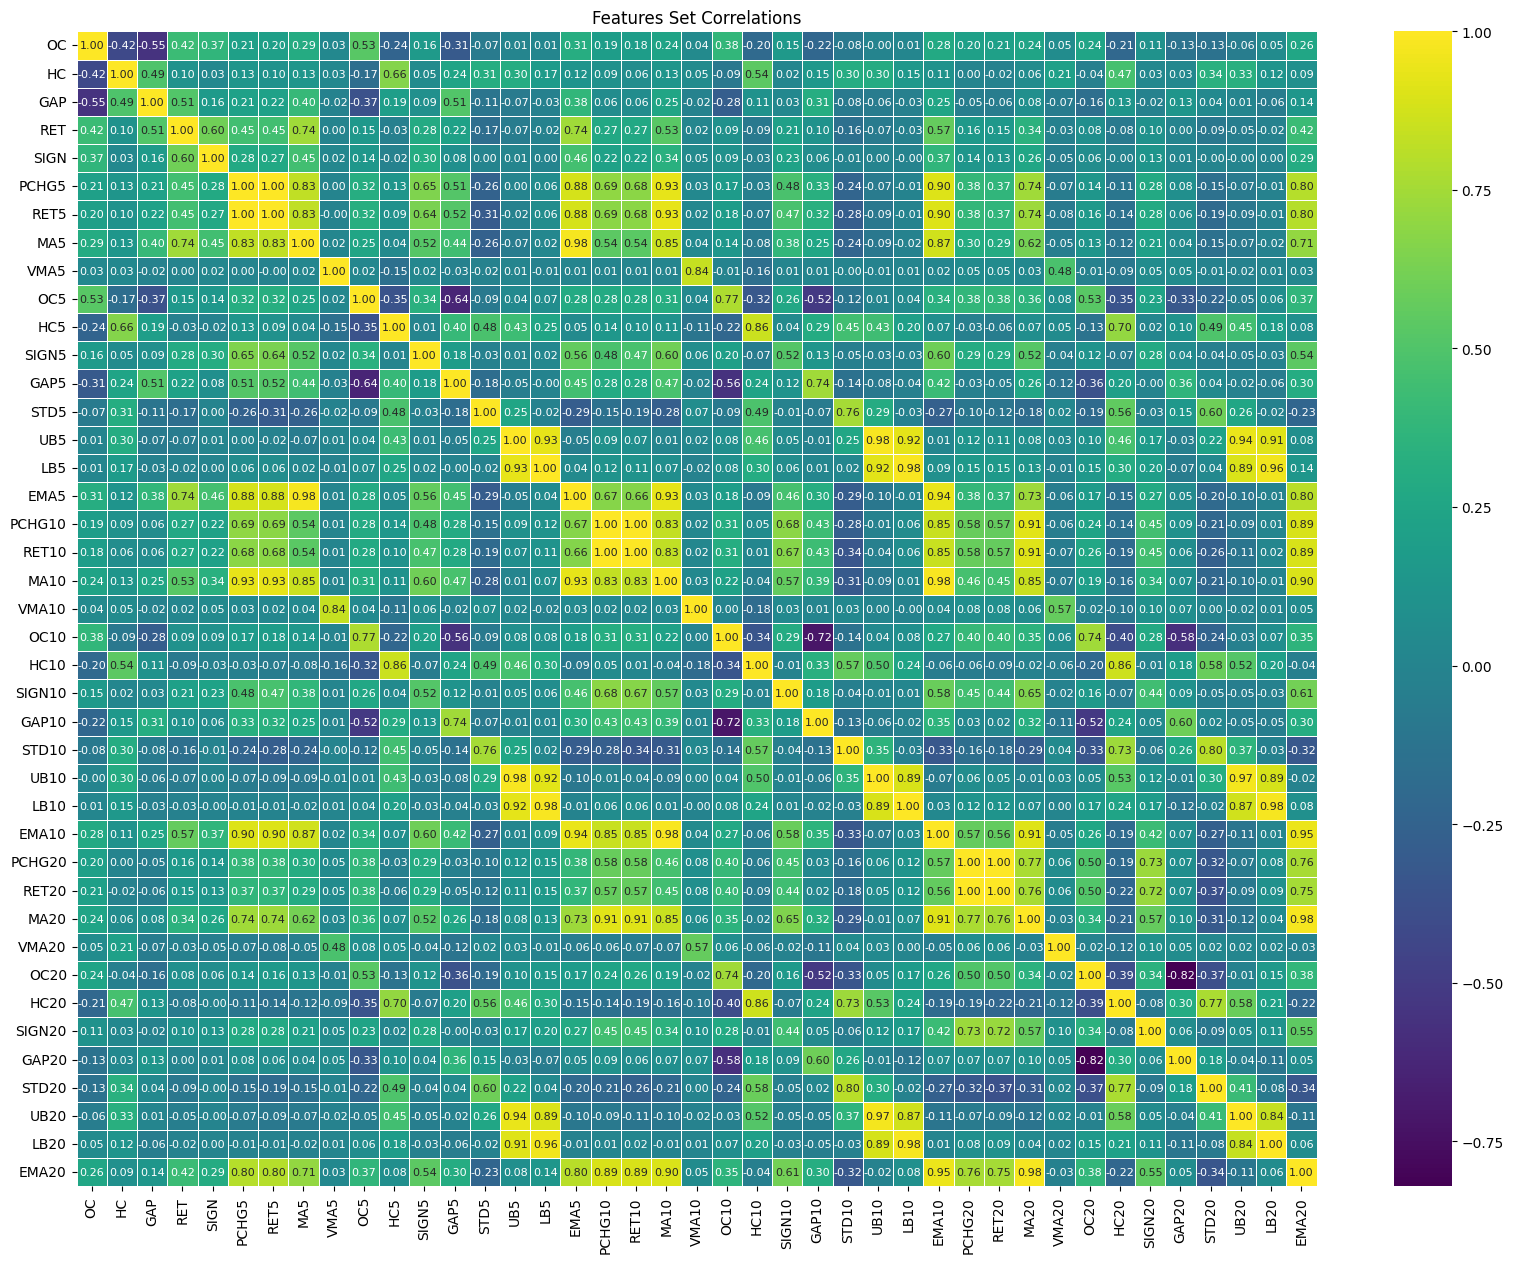

In [14]:
# remove features that are highly correlated
plt.subplots(figsize=(20,15))
sns.heatmap(X.corr(),
            annot=True,
            annot_kws={"size": 8},
            fmt=".2f",
            linewidth=.5,
            cmap="viridis",
            xticklabels=True, 
            yticklabels=True,
            cbar=True); #cmap="crest", viridis, magma
plt.title('Features Set Correlations');
plt.show()

It is generally unnecessary to eliminate features that exhibit correlation before running the Random Forest algorithm. Random Forest is inherently resilient to correlated features due to its ensemble of decision trees.

Here are a few reasons why you might not need to remove correlated features:

1. Feature Importance: Random Forest can provide measures of feature importance that indicate the comparative contribution of each feature in prediction. Therefore, even if correlated features are present, the algorithm can still identify and select the most informative ones.

2. Ensemble Nature: Random Forest aggregates predictions from multiple decision trees. As a result, it can handle correlated features by considering different combinations of features at various levels of the trees, thereby reducing the influence of any one feature.

3. Implicit Feature Selection: Random Forest includes a built-in feature selection mechanism. When constructing decision trees, only a random subset of features are considered at each node. This process implicitly diminishes the impact of correlated features, as different decision tree splits will focus on different subsets of features.

Nevertheless, in some cases, it could still be advantageous to remove highly correlated features, particularly for the sake of interpretability or when working with exceptionally large datasets. By eliminating correlated features, the model can be simplified and potentially improved in terms of efficiency.

Importantly, if highly correlated features lead to notable multicollinearity issues or detrimentally affect the performance of your Random Forest model, it might be worth exploring feature elimination or dimensionality reduction techniques.

In summary, while it is generally unnecessary to eliminate correlated features before employing Random Forest, there may be instances where removing such features could be advantageous. It is always beneficial to experiment with different feature sets and evaluate their impact on model performance and interpretability based on your specific dataset and problem.

#### 5.3.2 One wrapper method (SHAP) and Embedded method (Feature importance of Random Forest)
will be introduced later on the modeling stage as these are based on a model and the model we explore today is Random Forest Classifier

### 5.4 Target or Label Definition
Label or the target variable is also known as the dependent variable. Here, the target variable is the closing price of the index the next trading day

Label or the target variable is also known as the dependent variable. Here, the target variable is whether price will close up or down on the next trading day. If the tomorrow's closing price is greater than the median return of today's closing price, then we will buy an instument, else we will sell it. 

We use median as a good approach to tackels class impbalance so we will expect even distribution of up and down movements.

We assign a value of 1 for the buy signal and 0 for the sell signal to target variable. The target can be described as :

$$
y_{t}= \begin{cases}+1, & \text { if } p_{t+1}> (1+median(y_{t})) * p_{t} \\ -1, & \text { if } p_{t+1} \text { Otherwise }\end{cases}
$$

whre, $p_{t}$ is the current closing price of a commodity and $p_{t+1}$ is the 1-day forward closing price of the same.


The resulting data shape and median are give below:

In [15]:
print('Shape of features array: ',X.shape)
print('Shape of label array: ',y.shape)
print('The calculated median is equal to: ', X['RET'].median())

Shape of features array:  (1725, 41)
Shape of label array:  (1725,)
The calculated median is equal to:  0.0


In [16]:
# Target- Avoid using [-1, 1], always prefer [0, 1] as class labels
y = np.where(y.shift(-1)> (1+X['RET'].median())*y,1,0)
#y = np.where(y.shift(-1)> 1.01*y,1,0)
y

array([0, 1, 1, ..., 0, 0, 0])

In [17]:
# Value counts for class 1 and -1
print('The numbers of positive(1) and negative(0) classes are as follows') 
pd.Series(y).value_counts()

The numbers of positive(1) and negative(0) classes are as follows


0    883
1    842
dtype: int64

No class imbalance observed as we used median for distinguishing returns

## Step 6. Modeling and Hyperparameter tuning
### Step 6.1 Split Data

We split data using a standard train-test-split procedure with no shuffle as we work with time series data. 80% is devoted to train part, 20% - to test part.

In [18]:
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
#X = X[feature_imp.loc[feature_imp['Importance Score']>0.03,'Features']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=200)
 

In [19]:
# Output the train and test data size
print(f"Train and Test Sizes are: {len(X_train)}, {len(X_test)}")

Train and Test Sizes are: 1380, 345


### 6.2. Base Model

We now build a base model with default parameters using Pipelines. Since the KNN model calculates distances, the dataset needs to be scaled for the model to work properly. All the features should have a similar scale. The scaling can be accomplished by using the **MinMaxScaler transformer**.
#### 6.2.1 Fit Model

In [20]:
# Scale and fit the model
#X = X[feature_imp.loc[feature_imp['Importance Score']>0.03,'Features']]
model = Pipeline([
("classifier", RandomForestClassifier(random_state = np.random.seed(23)))])
model.fit(X_train, y_train)


Pipeline(steps=[('classifier', RandomForestClassifier())])

#### 6.2.2 Predict Model

In [21]:
# Predicting the test dataset
y_pred = model.predict(X_test)
# Predict Probabilities
y_proba = model.predict_proba(X_test)

In [22]:
# verify the class labels
model.classes_


array([0, 1])

In [23]:
# predict probability
y_proba[-20:]


array([[0.58, 0.42],
       [0.61, 0.39],
       [0.65, 0.35],
       [0.57, 0.43],
       [0.47, 0.53],
       [0.35, 0.65],
       [0.37, 0.63],
       [0.45, 0.55],
       [0.43, 0.57],
       [0.46, 0.54],
       [0.44, 0.56],
       [0.4 , 0.6 ],
       [0.44, 0.56],
       [0.46, 0.54],
       [0.39, 0.61],
       [0.37, 0.63],
       [0.43, 0.57],
       [0.35, 0.65],
       [0.34, 0.66],
       [0.33, 0.67]])

In [24]:
# predict class labels
y_pred[-20:]


array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 1.0, Test Accuracy: 0.5159


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.25      0.35       181
           1       0.49      0.81      0.61       164

    accuracy                           0.52       345
   macro avg       0.54      0.53      0.48       345
weighted avg       0.55      0.52      0.48       345



#### 6.2.3 Prediction Quality - Confusion Matrix
Confusion matrix is a table used to describe the performance of a classification model on a set of
test data for which the true values are known.

Confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known.

| Outcome | Position  |
| :--- | :--- |
| True Negative | upper-left |
| False Negative | lower-left |
| False Positive | upper-right |
| True Positive | lower-right |

True Positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.

False Positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.

Note: In a binary classification task, the terms "positive" and "negative" refer to the classifier's prediction, and the terms "true" and "false" refer to whether that prediction corresponds to the external judgment (sometimes known as the "observation") and the axes can be flipped. Refer Scikit-Learn Binary Classification for further details.


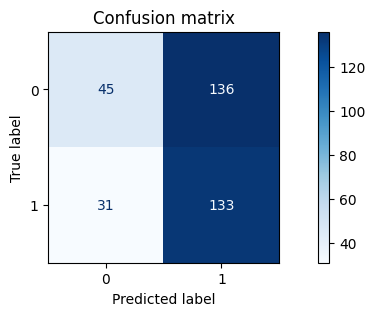

In [27]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
model,
X_test,
y_test,
# display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()


The confusion matrix tells us that model performance is rather poor given almost the same number for upper-right and lower-right quadrants. The base model can't predict upward movement 

#### 6.2.4 Classification Report
Classification report is a summary of the performance evaluation metrics for a classification model. Here are short descriptions of commonly used metrics in a classification report:

1. **Precision**: Precision measures the proportion of correctly identified positive instances out of all instances that are predicted as positive. It focuses on minimizing false positives.

2. **Recall**: Recall, also known as sensitivity or true positive rate, measures the proportion of correctly identified positive instances out of all actual positive instances. It focuses on minimizing false negatives.

3. **Accuracy**: Accuracy measures the overall correctness of the model by calculating the proportion of correctly predicted instances out of all instances. It considers both true positives and true negatives.

4. **F1 Score**: The F1 score provides a balance between precision and recall. It is the harmonic mean of precision and recall, providing a single metric that summarizes the model's performance.

5. **Support**: Support represents the count of each class in the actual data. It helps to understand the imbalance or distribution of classes in the dataset.

6. **Macro Average**: Average of precision (or recall or f1-score) of different classes.

7. **Weighted Average**: Actual Class1 instance * precision (or recall or f1-score) of Class1 + Actual Class2 instance * (or recall or f1-score) of Class2.



In [28]:
# Classification Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.59      0.25      0.35       181
           1       0.49      0.81      0.61       164

    accuracy                           0.52       345
   macro avg       0.54      0.53      0.48       345
weighted avg       0.55      0.52      0.48       345



The produced results are far from good ones; the model lacks accuracy and yields low stats on other parameters. The F1 score for positive class is not that bad, although the model is incapable of negative class prediction which makes the whole prediction inaccurate. 

#### 6.2.5 Receiver Operator Characteristic Curve (ROC)
The area under the ROC curve (AUC) is a measure of how well a model can distinguish between
two classes. The ROC curve is created by plotting the true positive rate (TPR) against the false
positive rate (FPR) at various classification thresholds

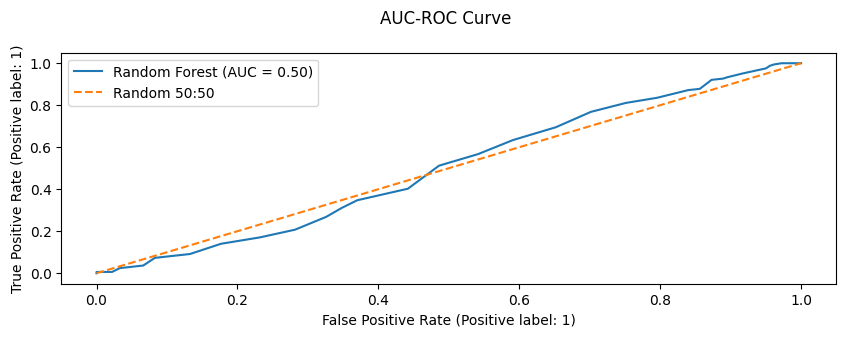

In [29]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
model,
X_test,
y_test,
name='Random Forest')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()


AUC of 0.50 is the same as random guessing. The model is no better than its absense.

Let's try to tune the model to come up with a better solution for the task!

### 6.3 Hyper-parameter Tuning

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they
are passed as arguments to the constructor of the estimator classes. It is possible and recommended
to search the hyper-parameter space for the best cross validation score. Any parameter provided
when constructing an estimator may be optimized in this manner.


#### 6.3.1 Cross-validation of Time Series
Time series data are sequential in nature and are characterised by the correlation between observations. Classical cross-validation techniques such as KFold assume the samples are independent and
identically distributed, and would result in poor estimates when applied on time series data.
To preserve the order and have training set occur prior to the test set, we use **Forward Chaining
method** in which the model is initially trained and tested with the same windows size. And, for
each subsequent fold, the training window increases in size, encompassing both the previous training
data and test data. The new test window once again follows the training window but stays the
same length.

We will tune the hyperparameters to select the best model by TimeSeriesSplit from scikitlearn. This is a forward chaining cross-validation method and is a variation from the KFold. In
the kth split, it returns first k folds as train set and the (k+1)th fold as test set. Unlike standard
cross-validation methods, successive training sets are supersets of those that come before them.

**We split the data into 4 parts** keeping one day in between to avoid ovelapping for the the label.


In [30]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=4, gap=1)

#### 6.3.2 GridSearch
The conventional way of performing hyperparameter optimization has been a grid search (aka parameter sweep). It is an exhaustive search through a manually specified subset of the hyperparameter
space of a learning algorithm. A grid search algorithm must be guided by some performance metric,
typically measured by cross-validation on the training set or evaluation on a validation set.
GridSearch performs exhaustive search over specified parameter values for an estimator. It implements a “fit” and a “score” method among other methods. The parameters of the estimator used to
apply these methods are optimized by cross-validated grid-search over a parameter grid.

**The most common Parameters of RandomForestClassifier (sklearn.ensemble) for tunning are given below:**

**n_estimators** : int, default=100
The number of trees in the forest. A higher number can improve performance but may slow down the training process.

**criterion** : {"gini", "entropy"}, default="gini"
The function to measure the quality of a split. "gini" uses the Gini impurity, and "entropy" uses the information gain.

**max_depth** : int, default=None
The maximum depth of the tree. A deeper tree can capture more complex relationships, but it can also lead to overfitting.

**max_features** : {"auto", "sqrt", "log2"}, int, float, or None, default="auto"
The number of features to consider when looking for the best split. Different options can be used, such as considering all features ("auto"), the square root of the total number of features ("sqrt"), the log2 of the total number of features ("log2"), a specific integer value, or a float representing a fraction of total features.

**max_leaf_node** : int, default=None
Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None, unlimited number of leaf nodes.


We will be using all of them **except for criterion** as empirically there is no much gain between two although entropy requires way more computation effort.

In [31]:
# Get parameters list
model.get_params()

{'memory': None,
 'steps': [('classifier', RandomForestClassifier())],
 'verbose': False,
 'classifier': RandomForestClassifier(),
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 100,
 'classifier__n_jobs': None,
 'classifier__oob_score': False,
 'classifier__random_state': None,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [32]:
# Best Params & Scores
param_grid = { 
    'classifier__n_estimators':  np.linspace(20, 200, 20, dtype = "int"), 
    'classifier__max_features': ['sqrt', 'log2', 10, 20, None], 
    'classifier__max_depth': [5, 7, 10, 15, 25, 50], 
    'classifier__max_leaf_nodes': [ 3, 5, 7, 10,],
    'classifier__random_state': [19],
            }



rs = RandomizedSearchCV(model, param_grid, n_iter=300,  n_jobs=-1, scoring='roc_auc', cv=tscv, verbose=1)
rs.fit(X_train, y_train)


Fitting 4 folds for each of 300 candidates, totalling 1200 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=4, test_size=None),
                   estimator=Pipeline(steps=[('classifier',
                                              RandomForestClassifier())]),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [5, 7, 10, 15,
                                                                  25, 50],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2', 10,
                                                                     20, None],
                                        'classifier__max_leaf_nodes': [3, 5, 7,
                                                                       10],
                                        'classifier__n_estimators': array([ 20,  29,  38,  48,  57,  67,  76,  86,  95, 105, 114, 124, 133,
       143, 152, 162, 171, 181, 190, 200]),
                                        'classifier__random_state': [19]},
                   scoring='roc_auc', verbose=1)

In [33]:
print('The parameters we are going to tune for are given below:')
param_grid


The parameters we are going to tune for are given below:


{'classifier__n_estimators': array([ 20,  29,  38,  48,  57,  67,  76,  86,  95, 105, 114, 124, 133,
        143, 152, 162, 171, 181, 190, 200]),
 'classifier__max_features': ['sqrt', 'log2', 10, 20, None],
 'classifier__max_depth': [5, 7, 10, 15, 25, 50],
 'classifier__max_leaf_nodes': [3, 5, 7, 10],
 'classifier__random_state': [19]}

In [34]:

print(f"Best Score: {round(rs.best_score_,4)}")

Best Score: 0.5331


In [35]:
print('The parameters we are going to tune for are given below:')
rs.best_params_

The parameters we are going to tune for are given below:


{'classifier__random_state': 19,
 'classifier__n_estimators': 86,
 'classifier__max_leaf_nodes': 7,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': 10}

## Step 7. Validation and Metrics

### 7.1 Tuned model assessment

Let’s fit the model with the best search parameters and see its performance:


In [36]:
## Instantiate RF model with search param
clf = RandomForestClassifier(
                             n_estimators = rs.best_params_['classifier__n_estimators'],
                            max_features = rs.best_params_['classifier__max_features'],
                             max_depth = rs.best_params_['classifier__max_depth'],
                             max_leaf_nodes = rs.best_params_['classifier__max_leaf_nodes'],
                                random_state = rs.best_params_['classifier__random_state']
                            )
# Fit the model
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_leaf_nodes=7, n_estimators=86,
                       random_state=19)

In [37]:
'''# Instantiate RF model with search param
clf = RandomForestClassifier(bootstrap = False,
                             n_estimators = rs.best_params_['classifier__n_estimators'],
                            max_features = rs.best_params_['classifier__max_features'],
                             max_depth = rs.best_params_['classifier__max_depth'],
                             max_leaf_nodes = rs.best_params_['classifier__max_leaf_nodes']
                            )
# Fit the model
clf.fit(X_train, y_train)'''

"# Instantiate RF model with search param\nclf = RandomForestClassifier(bootstrap = False,\n                             n_estimators = rs.best_params_['classifier__n_estimators'],\n                            max_features = rs.best_params_['classifier__max_features'],\n                             max_depth = rs.best_params_['classifier__max_depth'],\n                             max_leaf_nodes = rs.best_params_['classifier__max_leaf_nodes']\n                            )\n# Fit the model\nclf.fit(X_train, y_train)"

### 7.2 Metrics

#### 7.2.1 Predicting the test dataset

Train vs Test Accuracy

In [38]:
# Predicting the test dataset
y_pred = clf.predict(X_test)
# Predict Probabilities
# y_proba = clf.predict_proba(X_test)[:,1]

# Measure Accuracy
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t: {acc_train :0.4} \n Test Accuracy \t\t: {acc_test :0.4}')


 Training Accuracy 	: 0.6529 
 Test Accuracy 		: 0.5768


#### 7.2.2. Confusion Matrix

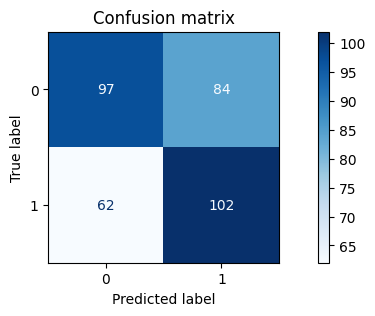

In [39]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
clf,
X_test,
y_test,
display_labels=model.classes_,
cmap=plt.cm.Blues
)
plt.title('Confusion matrix')
plt.show()


#### 7.2.3. Receiver Operator Characteristic Curve (ROC)

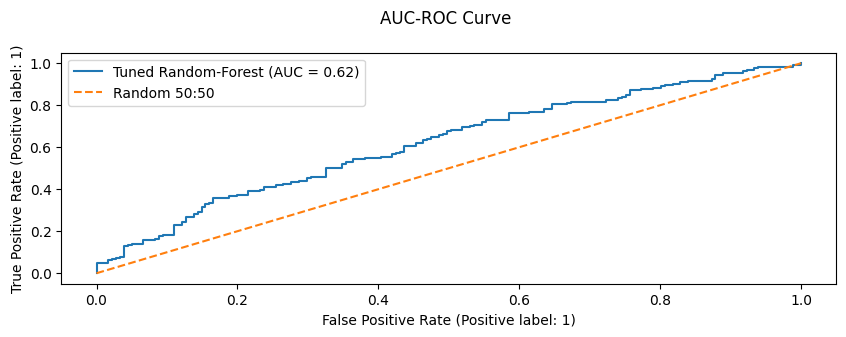

In [40]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
clf,
X_test,
y_test,
name='Tuned Random-Forest')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()


#### 7.2.4. Classification report

In [41]:
# Classification Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.61      0.54      0.57       181
           1       0.55      0.62      0.58       164

    accuracy                           0.58       345
   macro avg       0.58      0.58      0.58       345
weighted avg       0.58      0.58      0.58       345



#### 7.2.5. Results

**Comparison to Base model:**
1. Test accuracy improved by ~12% (from 0.52 to 0.58) as compared to the Base model.
2. Recall for Class 1 decreased but precision increased, while recall for Class 0 improved from 0.25 to 0.54. Model can predict both upside and downside movements with f1 score of 0.57-0.58.
3. The Model **improved AUC score by 12 p.p.** from 0.5 (random guessing) to 0.62, which is a decent result. Model can predict both upside and downside movements with f1 score of 0.57-0.58.
4. No class imbalance issue is ther for both given median-type of label specifying.



### 7.2 Feature importance

#### 7.2.1 Random Forest Feature importance Algorithm

In scikit-learn, the random forest algorithm not only provides accurate predictions but also offers a way to assess the importance of each feature in making those predictions. The importance of each feature is determined by calculating the decrease in node impurity (usually measured by Gini impurity or entropy) that results from splits over that feature across all trees in the forest. This is known as the Mean Decrease Impurity or the Gini importance. Here's a more detailed description of the feature importance algorithm based on random forest from scikit-learn:

- **Gini Importance or Mean Decrease in Impurity (MDI):** This method computes the total decrease in node impurity attributed to a feature, averaged over all trees in the ensemble. For each tree, the impurity decrease from each node is recorded and averaged across all trees to determine the overall importance of a particular feature. This metric essentially measures how much each feature contributes to decreasing the impurity of the nodes in the forest.

- **Interpretation:** Higher feature importance scores indicate that the feature is more influential in predicting the target variable. Features with low importance scores are less influential in the prediction process.

- **Usage:** Feature importance scores can be utilized for various tasks such as feature selection, identifying the most significant features for interpreting the model's predictions, and understanding the key drivers behind the predictions made by the random forest model. 

It is important to note that the feature importances obtained from the random forest algorithm provide valuable insights into the relevance of features for the given prediction task. However, these scores are not a measure of causal relationships, and interpretation should be cautious, especially in the case of correlated features.

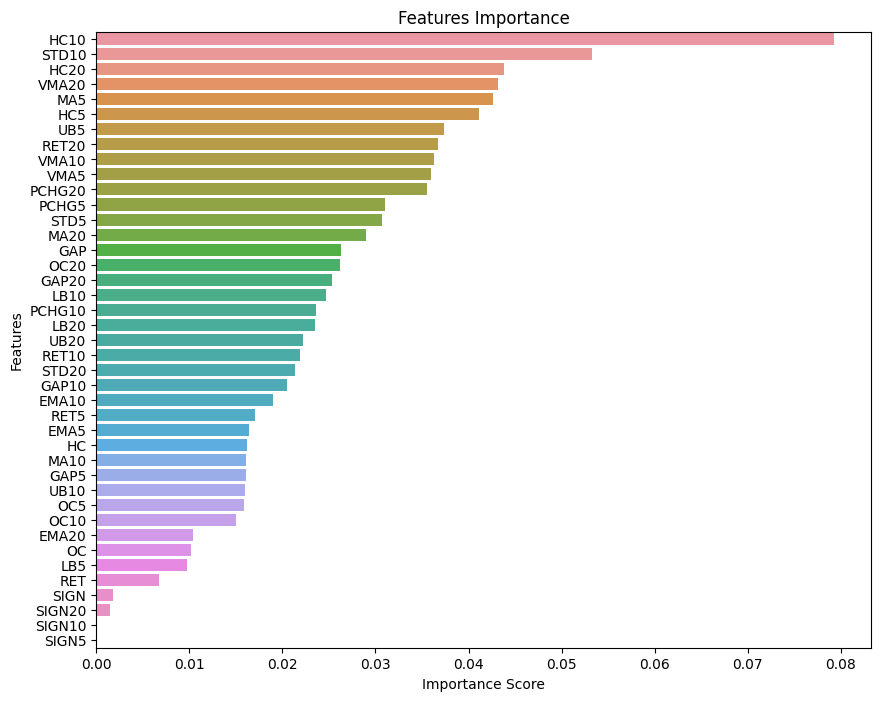

In [42]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': clf.feature_importances_,\
                            'Features': X.columns}).sort_values(by='Importance Score', ascending=False)

sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance');


#### 7.2.2 The SHAPley analysis

The SHAP (SHapley Additive exPlanations) method is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. The SHAP method offers a unified approach to explain the output of any machine learning model. Here's a description of the SHAP method:

- **Shapley Values**: In cooperative game theory, Shapley values are used to fairly distribute the "payout" among the players. In the context of machine learning, Shapley values show how to fairly distribute the "credit" for the prediction among the features. Essentially, SHAP values provide a unified way to explain the output of any machine learning model by quantifying the contribution of each feature to the predicted outcome.
- **Usage:** SHAP values are valuable for interpreting black-box models, identifying key features driving individual predictions, and understanding the impact of different features on model predictions. They are also useful for validating the model's behavior and ensuring it aligns with domain knowledge.

The SHAP method has gained significant attention for its ability to provide both local and global feature importance explanations, thereby enhancing the interpretability of complex machine learning models. It helps users understand the impact of various features on model predictions in a more nuanced and precise manner.

In [43]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

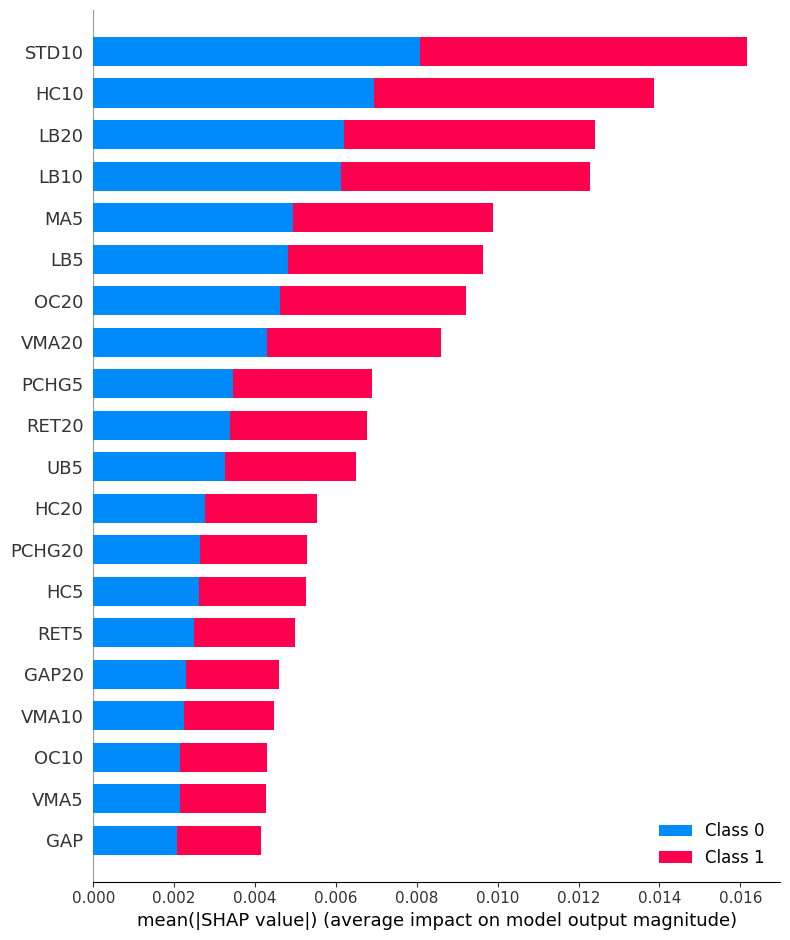

In [44]:
# future importance summary
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

#### 7.2.3. Comparison of methods
The results (top 10) are rather simillar but some features such as LB20, LB10, HC20, or OC20 differ which is quite an interesting observation.
Overall, we see that Moving averages, Open-Close differences, L/U bounds have the most importance, while features like returns, % changes, gaps and signs didn't bring much value.

### 7.4 Trading Strategy
Let’s now define a trading strategy. We will use the predicted signal to buy or sell. We then
compare the result of this strategy with the buy and hold and visualize the performance of the
Random Forest Algorithm.

The results are below in the table and in the charts:

1. Strategy performs relatively well (annual return - 15.96%), however a bit worse than on the In-sample data where an. return showed 67.28%. 
2. **Hold and buy strategy would yield us approx. -10.7% (vs +22.47% buy using the model)**
3. Sharp ratio is slightly above 1 on out-of-sample.


In [45]:
# Subsume into a new dataframe

df2 = X.copy() # df[-len(X_test)
df2['Signal'] = clf.predict(X)# clf.predict(X_test)
df2

,OC,HC,GAP,RET,SIGN,PCHG5,RET5,MA5,VMA5,OC5,...,VMA20,OC20,HC20,SIGN20,GAP20,STD20,UB20,LB20,EMA20,Signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-31 00:00:00-04:00,0.0,10.0,-1.5,-0.001521,-1.0,0.000508,0.000507,0.991449,0.230289,-1.2,...,0.258744,1.225,21.100,-1.0,-1.375,0.017129,1059.292651,968.357349,0.979398,0
2016-11-01 00:00:00-04:00,-22.0,30.0,-3.0,-0.025695,-1.0,-0.023386,-0.023664,0.970790,0.301095,-4.7,...,0.300906,-1.025,19.950,-1.0,-1.275,0.017473,1064.762575,958.287425,0.958702,0
2016-11-02 00:00:00-04:00,-13.0,15.0,-3.0,-0.016798,-1.0,-0.055028,-0.056599,0.965352,0.286932,-11.0,...,0.238855,-1.900,20.050,-1.0,-1.350,0.017714,1071.964193,944.585807,0.947902,0
2016-11-03 00:00:00-04:00,-5.5,14.0,15.5,0.010532,1.0,-0.059142,-0.060964,0.987686,0.134430,-13.7,...,0.080216,-2.000,20.175,-1.0,-0.475,0.017972,1075.386997,936.213003,0.961791,0
2016-11-04 00:00:00-04:00,5.0,11.0,4.5,0.009904,1.0,-0.023303,-0.023579,1.002287,0.834236,-7.1,...,0.185475,-2.125,20.100,-1.0,-0.225,0.018065,1076.266939,930.633061,0.974020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-22 00:00:00-04:00,1.5,12.0,1.5,0.001898,1.0,-0.024052,-0.024346,0.993721,0.821226,-6.9,...,0.950988,4.200,18.725,1.0,-3.650,0.015364,1710.848455,1533.701545,0.984368,0
2023-09-25 00:00:00-04:00,2.5,17.0,0.0,0.001579,1.0,-0.010303,-0.010356,0.997357,0.996678,-1.5,...,1.207243,4.500,18.375,1.0,-3.650,0.015354,1709.127499,1537.122501,0.987247,0
2023-09-26 00:00:00-04:00,32.0,38.5,2.0,0.021224,1.0,0.009981,0.009932,1.016704,1.167147,3.9,...,1.525065,4.225,18.325,1.0,-3.675,0.015041,1709.314929,1538.035071,1.007616,1


In [46]:
# Daily Returns - Benchmark return
df2['Returns'] = np.log(label).diff().fillna(0)
# Strategy Returns - KNN
df2['Strategy'] = df2['Returns'] * df2['Signal'].shift(1).fillna(0)
# Localize index for pyfolio
df2.index = df2.index.tz_convert('UTC')#tz_localize('utc')


In [47]:
# Check the output
df2.tail(10)

,OC,HC,GAP,RET,SIGN,PCHG5,RET5,MA5,VMA5,OC5,...,HC20,SIGN20,GAP20,STD20,UB20,LB20,EMA20,Signal,Returns,Strategy
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-15 04:00:00+00:00,-1.0,15.0,-23.5,-0.014996,-1.0,0.007143,0.007117,1.008145,1.225806,5.3,...,17.275,1.0,-3.575,0.015285,1725.290432,1500.059568,1.002005,1,-0.012411,-0.012411
2023-09-18 04:00:00+00:00,-24.5,32.5,4.5,-0.012411,-1.0,0.012646,0.012567,0.993240,1.168109,0.4,...,18.475,1.0,-3.375,0.015627,1723.280940,1506.769060,0.990623,0,0.000936,0.000936
2023-09-19 04:00:00+00:00,5.0,22.0,-3.5,0.000936,1.0,0.013915,0.013819,0.991465,1.157480,-0.2,...,18.800,1.0,-3.625,0.015607,1720.409170,1514.790830,0.992349,0,-0.004376,-0.000000
2023-09-20 04:00:00+00:00,0.0,24.5,-7.0,-0.004376,-1.0,-0.009926,-0.009975,0.989093,0.391918,-4.1,...,19.350,1.0,-3.975,0.015650,1716.525545,1523.374455,0.989145,0,-0.010392,-0.000000
2023-09-21 04:00:00+00:00,-16.5,20.5,0.0,-0.010392,-1.0,-0.040401,-0.041240,0.987002,1.054087,-7.4,...,19.875,1.0,-3.925,0.015844,1711.881149,1531.568851,0.980888,0,0.001898,0.000000
2023-09-22 04:00:00+00:00,1.5,12.0,1.5,0.001898,1.0,-0.024052,-0.024346,0.993721,0.821226,-6.9,...,18.725,1.0,-3.650,0.015364,1710.848455,1533.701545,0.984368,0,0.001579,0.000000
2023-09-25 04:00:00+00:00,2.5,17.0,0.0,0.001579,1.0,-0.010303,-0.010356,0.997357,0.996678,-1.5,...,18.375,1.0,-3.650,0.015354,1709.127499,1537.122501,0.987247,0,0.021224,0.000000
2023-09-26 04:00:00+00:00,32.0,38.5,2.0,0.021224,1.0,0.009981,0.009932,1.016704,1.167147,3.9,...,18.325,1.0,-3.675,0.015041,1709.314929,1538.035071,1.007616,1,-0.000927,-0.000000
2023-09-27 04:00:00+00:00,-1.5,21.0,0.0,-0.000927,-1.0,0.013471,0.013381,1.013027,1.281818,3.6,...,16.450,-1.0,-3.500,0.013501,1705.813318,1537.836682,1.006042,0,-0.002786,-0.002786


In [48]:
# Import pyfolio
import pyfolio as pf
print(X_test.head())

                             OC     HC   GAP       RET  SIGN     PCHG5  \
Date                                                                     
2022-05-16 00:00:00-04:00  43.5   78.5  24.0  0.038604   1.0  0.080630   
2022-05-17 00:00:00-04:00 -63.5  116.0  -2.5 -0.037730  -1.0  0.034971   
2022-05-18 00:00:00-04:00 -31.0   40.5  -4.5 -0.020898  -1.0  0.007492   
2022-05-19 00:00:00-04:00  23.0   34.0  -5.5  0.010357   1.0  0.002952   
2022-05-20 00:00:00-04:00  25.5   37.5  -7.5  0.010542   1.0  0.000875   

                               RET5       MA5      VMA5   OC5  ...      MA20  \
Date                                                           ...             
2022-05-16 00:00:00-04:00  0.077545  1.046314  3.571826  12.9  ...  1.069735   
2022-05-17 00:00:00-04:00  0.034374  1.000758  1.694506  -2.8  ...  1.026738   
2022-05-18 00:00:00-04:00  0.007464  0.978634  1.355051 -10.2  ...  1.003238   
2022-05-19 00:00:00-04:00  0.002948  0.988247  0.451678  -5.6  ...  1.011403   
2

In [49]:
# Create Tear sheet using pyfolio for outsample - for X_test
#pf.create_simple_tear_sheet(df2['Strategy'])

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.71,2023-01-09,2023-03-07,2023-04-11,66
1,10.42,2022-05-13,2022-07-01,2022-09-08,85
2,10.12,2018-07-13,2018-09-18,2019-01-17,135
3,9.25,2023-05-11,2023-05-24,2023-06-08,21
4,7.87,2023-07-11,2023-07-13,2023-09-12,46


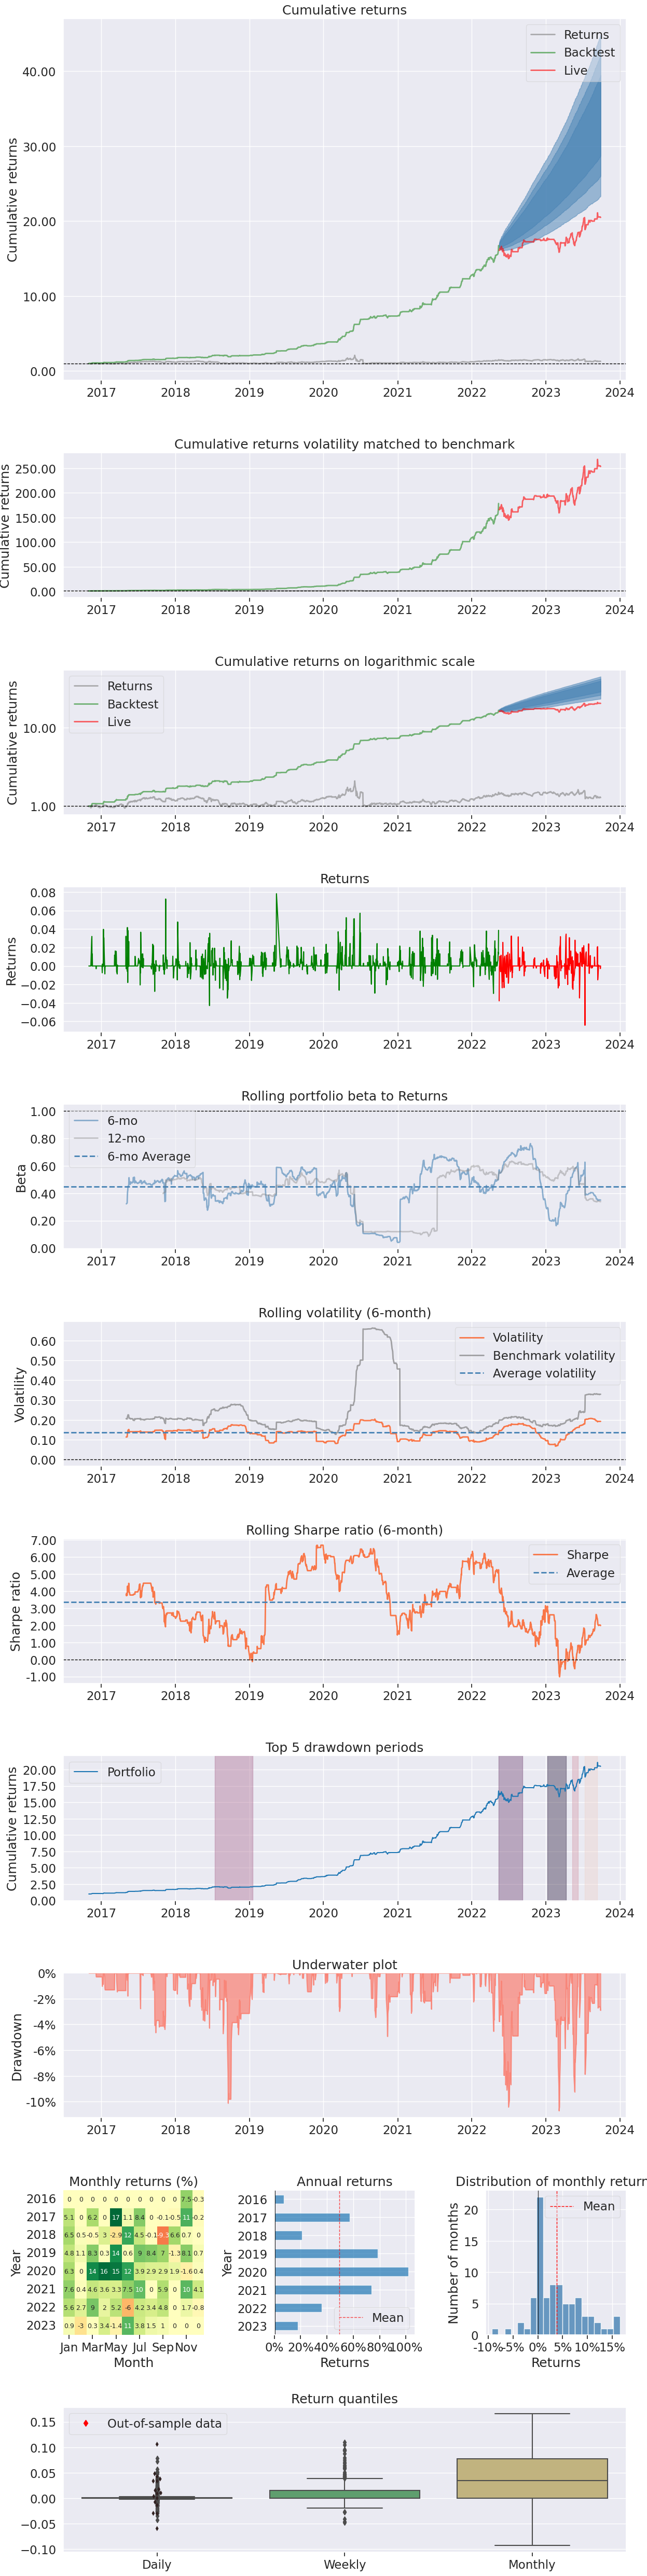

In [50]:
# Live start date 2016-04-07
pf.create_returns_tear_sheet(df2['Strategy'], live_start_date='2022-05-16', benchmark_rets=df2['Returns'])


## ANNEX

In [51]:
# Below we import BeautifulSoup library to extract all commodity codes from https://finance.yahoo.com/commodities/ 
# This code sends a GET request to the provided URL, parses the HTML content using BeautifulSoup, 
# finds the table containing the data, determines the index of the "Symbol" column, 
# and then iterates over the table rows to extract and print the symbols from the "Symbol" column.

import requests
from bs4 import BeautifulSoup
import pandas as pd

# Send a GET request to the webpage
url = "https://finance.yahoo.com/commodities/"
response = requests.get(url)

# Parse the content using BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Find the table with the data
table = soup.find("table", {"class": "W(100%)"})

# Find the header row
header_row = table.find("thead").find_all("th")

# Find the indices of the "Symbol" and "Name" columns
symbol_index = 0
name_index = 0
for idx, th in enumerate(header_row):
    if th.text.strip() == "Symbol":
        symbol_index = idx
    elif th.text.strip() == "Name":
        name_index = idx

# Initialize lists to store Symbol and Name data
symbols = []
names = []

# Iterate over the table rows and store Symbol and Name data
tbody = table.find("tbody")
for row in tbody.find_all("tr"):
    columns = row.find_all("td")
    symbol = columns[symbol_index].text.strip()
    name = columns[name_index].text.strip()
    symbols.append(symbol)
    names.append(name)

# Create a dataframe from the collected data
data = {"Symbol": symbols, "Name": names}
tickers = pd.DataFrame(data)

# Print the dataframe
# tickers
# It look like the list contains not only commodities but futures on indices too. We need to drop these from the sample.
tickers = tickers.drop([0,1,2,3,4,5,6,7,20,25,28,34])
print('The list of tickers parsed from Yahoo')
tickers

The list of tickers parsed from Yahoo


,Symbol,Name
8,GC=F,Gold
9,MGC=F,"Micro Gold Futures,Dec-2023"
10,SI=F,Silver
11,SIL=F,"Micro Silver Futures,Dec-2023"
12,PL=F,Platinum Jan 24
13,HG=F,Copper Dec 23
14,PA=F,Palladium Dec 23
15,CL=F,Crude Oil
16,HO=F,Heating Oil Nov 23
17,NG=F,Natural Gas Nov 23


In [52]:
for ticker in tickers['Symbol']:
    df = load_data(ticker, start='2016-09-30', end = '2023-09-30')
    X,y = create_features(df)
    y = np.where(y.shift(-1)>(1+X['RET'].median())*y,1,0) #1.01*y,1,0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    # Scale and fit the model
    model = Pipeline([("classifier", RandomForestClassifier(n_estimators = 100,
                            max_features = 'sqrt',
                             max_depth = 15,
                             max_leaf_nodes = 10, random_state = np.random.seed(200)))])
    #model = Pipeline([("classifier", RandomForestClassifier(bootstrap = False))])
    model.fit(X_train, y_train)
    # Predicting the test dataset
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba[:, 1]) 
    print(f'Ticker: {ticker},Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}, AUC: {auc:0.4}' )

Ticker: GC=F,Train Accuracy: 0.7408, Test Accuracy: 0.5316, AUC: 0.5595
Ticker: MGC=F,Train Accuracy: 0.7215, Test Accuracy: 0.4709, AUC: 0.5136
Ticker: SI=F,Train Accuracy: 0.7363, Test Accuracy: 0.4755, AUC: 0.4825
Ticker: SIL=F,Train Accuracy: 0.7474, Test Accuracy: 0.5296, AUC: 0.5561
Ticker: PL=F,Train Accuracy: 0.7312, Test Accuracy: 0.5092, AUC: 0.5627
Ticker: HG=F,Train Accuracy: 0.7271, Test Accuracy: 0.5661, AUC: 0.5724
Ticker: PA=F,Train Accuracy: 0.7488, Test Accuracy: 0.4396, AUC: 0.5315
Ticker: CL=F,Train Accuracy: 0.7283, Test Accuracy: 0.5174, AUC: 0.5232
Ticker: HO=F,Train Accuracy: 0.7374, Test Accuracy: 0.4626, AUC: 0.4763
Ticker: NG=F,Train Accuracy: 0.7065, Test Accuracy: 0.5172, AUC: 0.5201
Ticker: RB=F,Train Accuracy: 0.7165, Test Accuracy: 0.5374, AUC: 0.514
Ticker: BZ=F,Train Accuracy: 0.6847, Test Accuracy: 0.5331, AUC: 0.5299
Ticker: ZC=F,Train Accuracy: 0.6837, Test Accuracy: 0.4799, AUC: 0.5078
Ticker: ZO=F,Train Accuracy: 0.733, Test Accuracy: 0.5389, AUC: